<a href="https://colab.research.google.com/github/somendrew/Practise-with-Projects/blob/main/Internship_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

def kaggleSetUp():
  !pip install kaggle
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir  ~/.kaggle
  !cp /content/drive/MyDrive/Kaggle/Kaggle_Credential/kaggle.json ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle config --list


kaggleSetUp()

Dataset:- # adityamahimkar/iqothnccd-lung-cancer-dataset/data

In [1]:
%%capture
#pneumonia dataset
!kaggle datasets download adityamahimkar/iqothnccd-lung-cancer-dataset
!unzip iqothnccd-lung-cancer-dataset.zip


In [2]:
import os
from PIL import Image
import imageio
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras import layers,models,optimizers
from tensorflow.keras.applications import EfficientNetB7

In [3]:
directory = r'/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

In [4]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1

    size_data[i] = temp_dict

size_data

<ipython-input-4-b77470758d58>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  height, width, channels = imageio.imread(filepath).shape


{'Bengin cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '512 x 801': 28,
  '512 x 623': 31,
  '404 x 511': 1},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Bengin cases


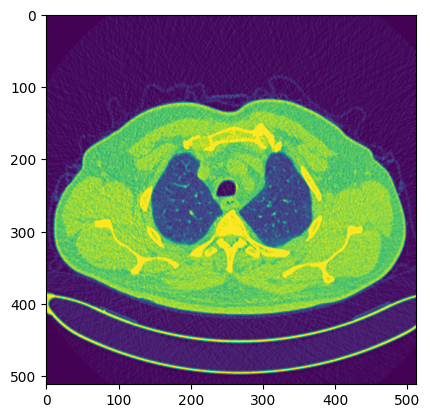

Malignant cases


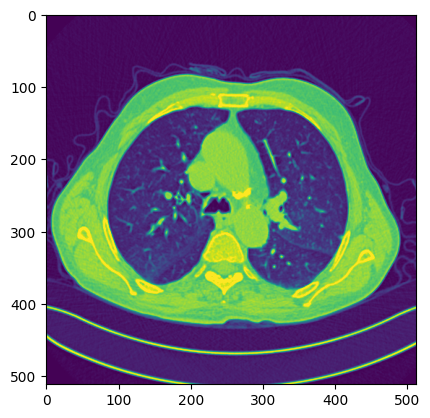

Normal cases


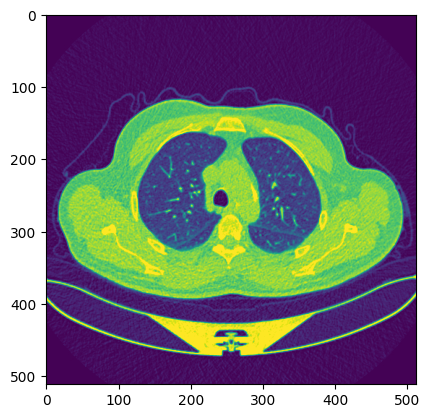

In [5]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

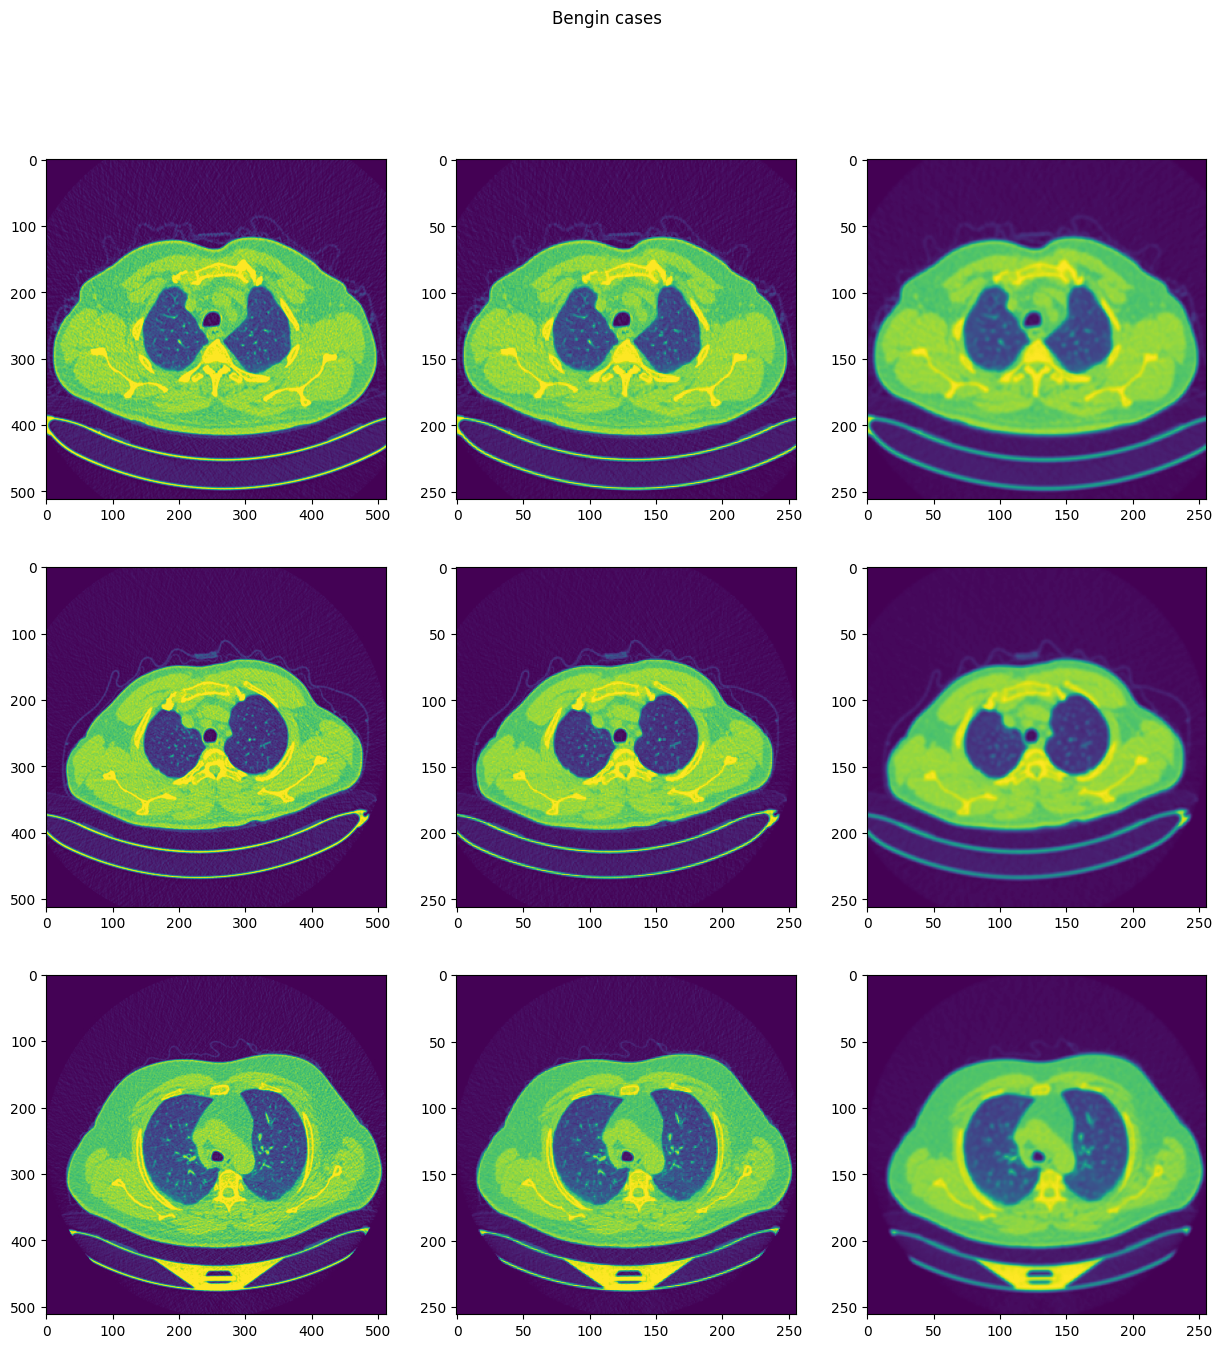

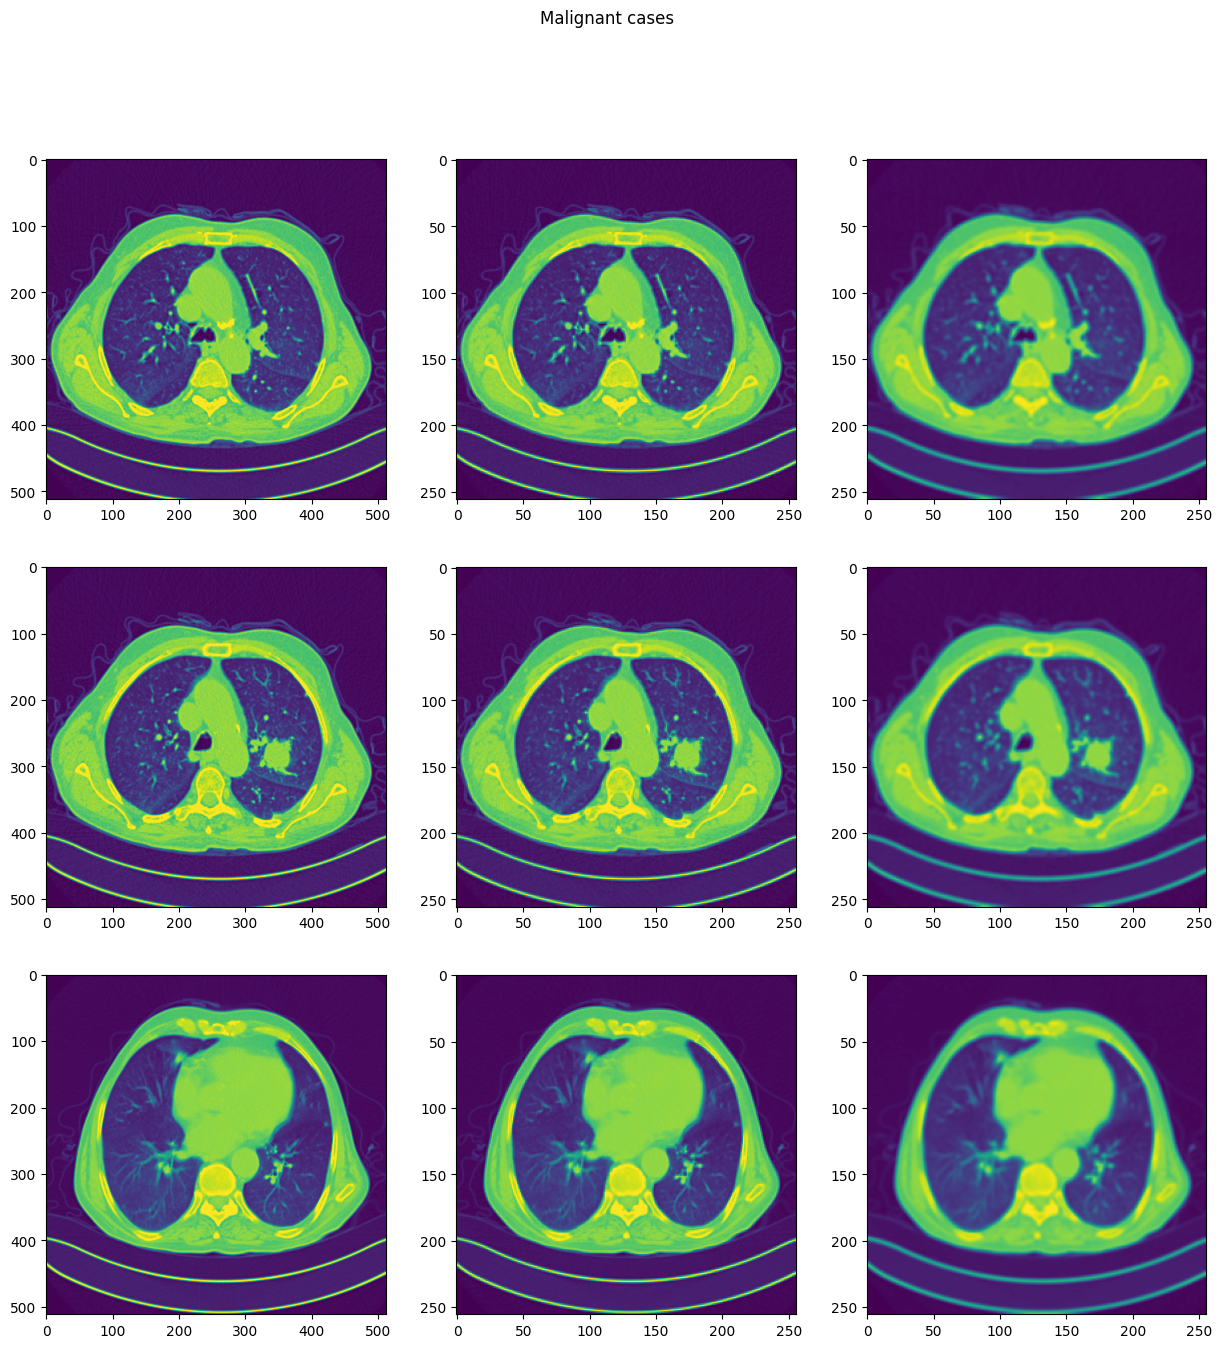

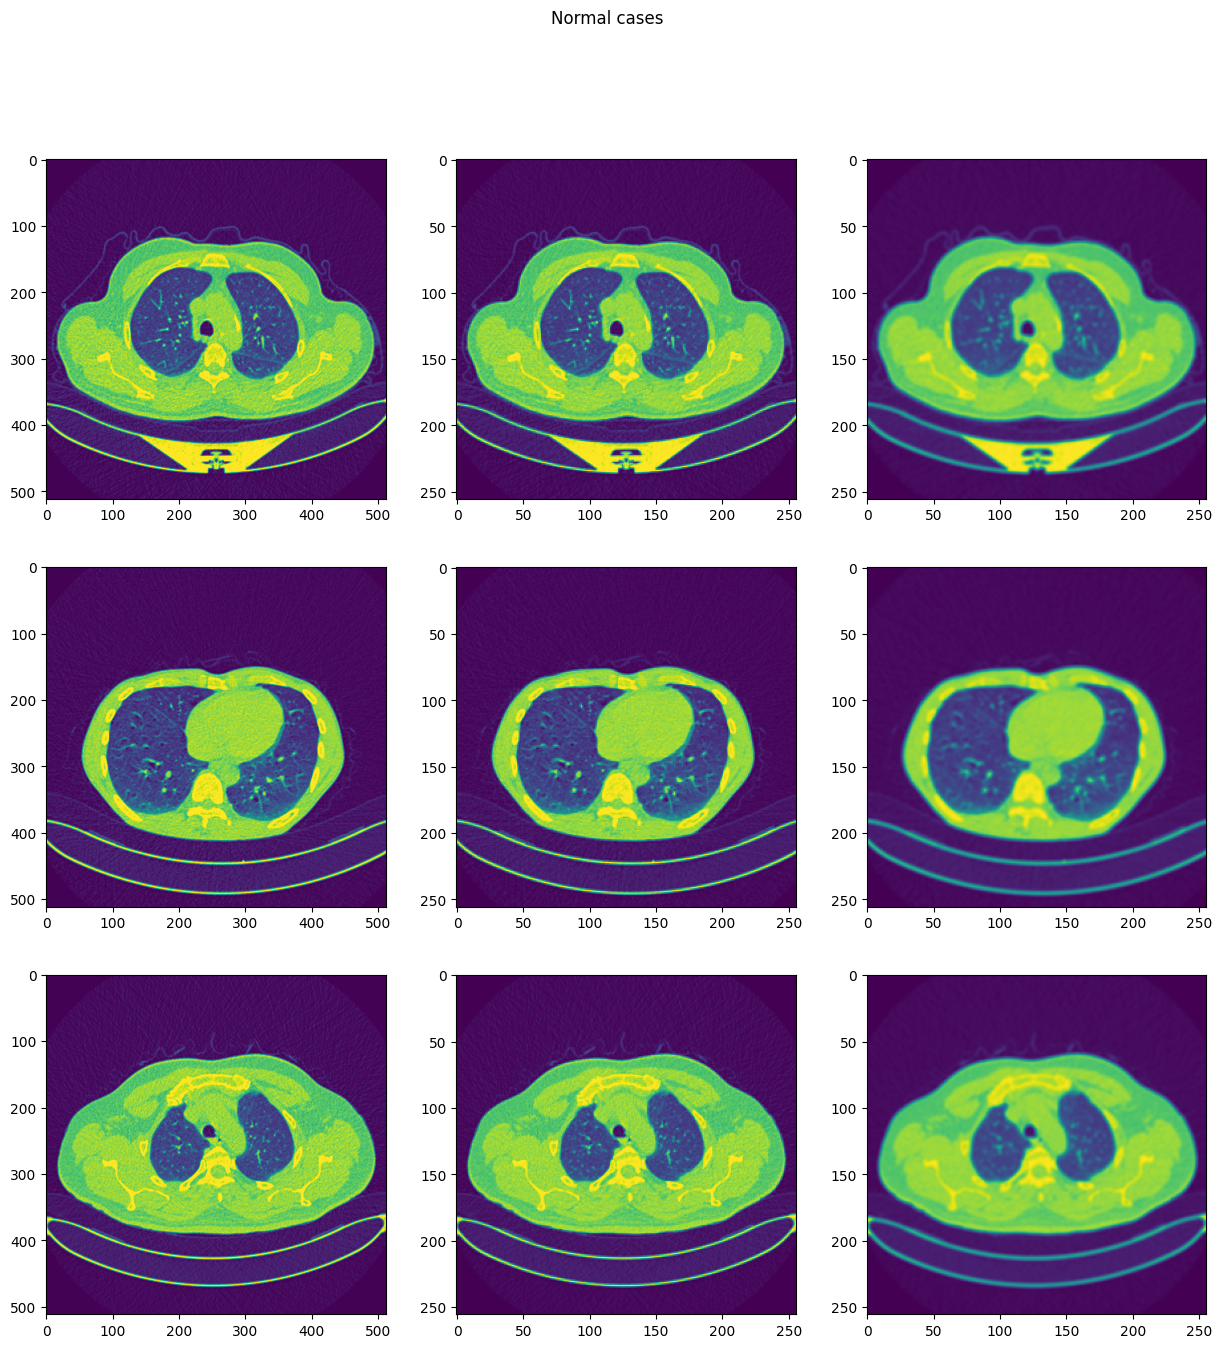

In [6]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)

    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)

        img0 = cv2.resize(img, (img_size, img_size))

        img1 = cv2.GaussianBlur(img0, (5, 5), 0)

        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break

plt.show()


In [7]:
import numpy as np
from collections import Counter
import random
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath)  # Load in RGB format by default
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

# Shuffle the data
random.shuffle(data)

# Prepare X and y
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

# Normalize X
X = np.array(X) / 255.0  # Normalize pixel values
y = np.array(y)

# Check the shapes and counts
print('X length:', len(X))
print('y counts:', Counter(y))


X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [8]:
X.shape

(1097, 256, 256, 3)

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)


822 (822, 256, 256, 3)
275 (275, 256, 256, 3)


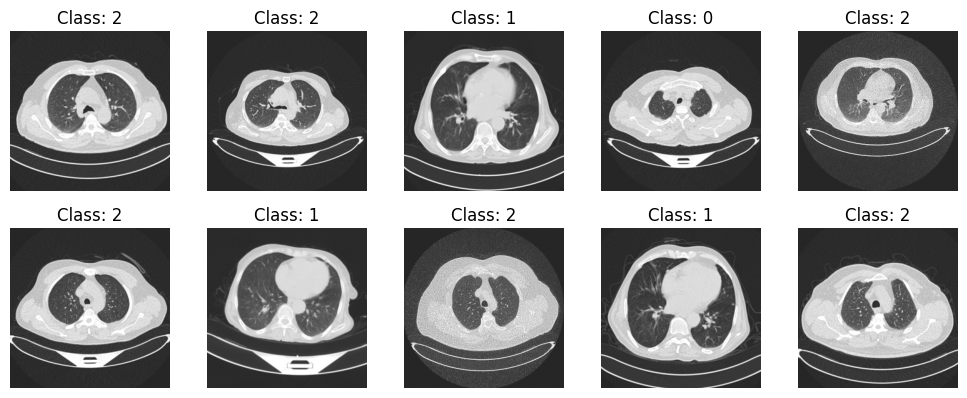

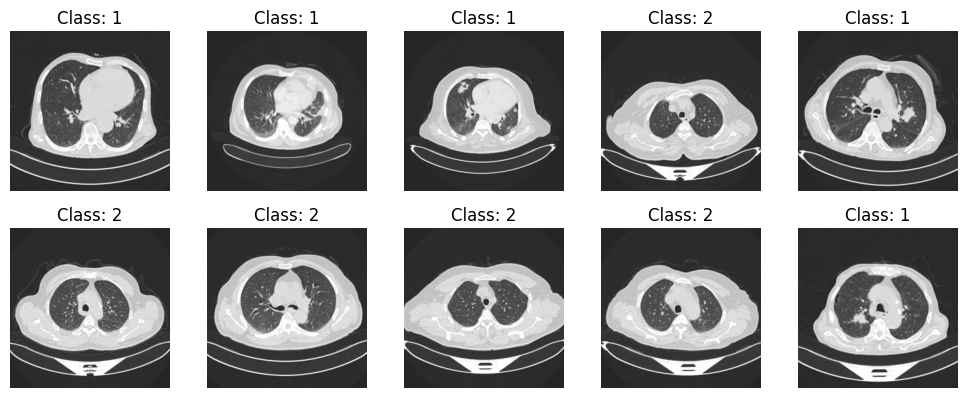

In [10]:
import matplotlib.pyplot as plt

# Display images from X_train
plt.figure(figsize=(10, 10))
for i in range(10):  # Displaying 10 images
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.title(f"Class: {y_train[i]}")
plt.tight_layout()
plt.show()

# Display images from X_valid
plt.figure(figsize=(10, 10))
for i in range(10):  # Displaying 10 images
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_valid[i], cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.title(f"Class: {y_valid[i]}")
plt.tight_layout()
plt.show()


In [11]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [12]:
X_train.shape


(822, 256, 256, 3)

# Model Building

In [13]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau

In [14]:

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [15]:
# Instantiate the EfficientNetB7 model
base_model = EfficientNetB7(weights='imagenet',
                            include_top=False,
                            input_shape=(256,256,3), # input shape is defined here
                            classes= 3)


# Freeze the base model layers
base_model.trainable = False


# Create a new model on top of EfficientNetB7
model = models.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)), # input layer
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

model.summary()


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 8, 8, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,426,394 (245.77 MB)

 Trainable params: 328,451 (1.25 MB)

 Non-trainable params: 64,097,943 (244.51 MB)

In [16]:
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs= 25,
    validation_data=(X_valid, y_valid),
    callbacks=[learning_rate_reduction]
)


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.3232 - loss: 1.4340 - val_accuracy: 0.1091 - val_loss: 1.1903 - learning_rate: 1.0000e-04
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 422ms/step - accuracy: 0.3965 - loss: 1.2849 - val_accuracy: 0.1091 - val_loss: 1.1668 - learning_rate: 1.0000e-04
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 425ms/step - accuracy: 0.3481 - loss: 1.3276 - val_accuracy: 0.3782 - val_loss: 1.1108 - learning_rate: 1.0000e-04
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - accuracy: 0.3536 - loss: 1.2746 - val_accuracy: 0.3782 - val_loss: 1.1037 - learning_rate: 1.0000e-04
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3694 - loss: 1.2484
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step - accuracy: 0.3691 - loss: 1.2487 - val_accuracy: 0.3782 - val_loss: 1.0974 - learning_rate: 1.0000e-04
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 

In [ ]:
from sklearn.metrics import  classification_report, confusion_matrix

In [ ]:
y_pred = model.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
BATCH_SIZE = 8

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=(0.75,1),
                                   brightness_range=(0.75,1.25)
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(X_valid, y_valid, batch_size=BATCH_SIZE, shuffle= False)

In [ ]:
# Instantiate the EfficientNetB7 model
base_model = EfficientNetB7(weights='imagenet',
                            include_top=False,
                            input_shape=(256,256,3),
                            classes= 3)

# Unfreeze some layers for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before the fine-tune starting layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Create a new model on top of EfficientNetB0
model3 = models.Sequential([
    layers.InputLayer(input_shape=(256, 256, 3)), # input layer
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model3.summary()

In [ ]:
# Compile the model
model3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model3.fit(
    train_generator,
    epochs= 50,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction]
)

In [ ]:
y_pred = model3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


report = classification_report(y_valid, y_pred_bool)
conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred_bool)

In [ ]:
print("\nClassification Report:")
print(conf_mat)
print("\nClassification Report:")
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred_bool)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
